In [1]:
import pandas as pd 
import datetime
import numpy as np 
import scipy as sp
from scipy.stats import mode
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## Computing the distribution of correlation coefficients

In [2]:
# import dataframes
raw_df = pd.read_csv("../data/Per_Patient/patient_firstidx_merge.csv", low_memory=False)
merge_df = pd.read_csv("../data/ADNIMERGE.csv", low_memory=False)

In [3]:
drop_cols=["PTID","VISCODE","SITE","COLPROT","ORIGPROT","EXAMDATE","M","Month"]

In [4]:
by_vis = merge_df.groupby("VISCODE")
bl_df = by_vis.get_group("bl")

In [5]:
bl_df = bl_df.set_index("RID")
bl_df = bl_df.drop(columns=drop_cols, axis=1)
bl_df = bl_df.drop(columns=bl_df.columns[bl_df.dtypes==np.object],axis=1)

In [6]:
raw_df.replace({-1: np.nan}, inplace=True)
raw_df = raw_df.set_index("RID")

In [7]:
mdf = pd.concat((bl_df,raw_df), axis=1)

In [8]:
r=mdf.corr().values

In [9]:
rand_vals = np.random.rand(mdf.shape[0],mdf.shape[1])
rand_vals[mdf.isna()] = np.nan
rand_df = pd.DataFrame(rand_vals)
r_null = rand_df.corr().values

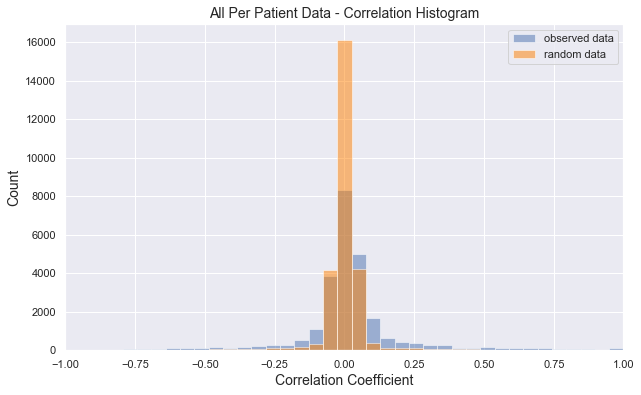

In [10]:
plt.figure(figsize=(10,6))
all_coef = np.empty([])
null_coef = np.empty([])
for i in range(r.shape[0]):
    for j in range(i):
        if i != j:
            all_coef = np.append(all_coef,r[i,j])
            null_coef = np.append(null_coef,r_null[i,j])
            
all_coef = all_coef[~np.isnan(all_coef)]
null_coef = null_coef[~np.isnan(null_coef)]
bins = np.linspace(-1,1,40)
plt.hist(all_coef, bins, color='b', alpha=0.5, label="observed data")
plt.hist(null_coef, bins, color=(1,.5,0), alpha=0.5, label="random data")
plt.xlabel("Correlation Coefficient", Fontsize=14)
plt.ylabel("Count", Fontsize=14)
plt.title("All Per Patient Data - Correlation Histogram", Fontsize=14)
plt.xlim([-1,1])
plt.legend();
plt.savefig("../figures/corrcoef_hist.svg")

## Missingness

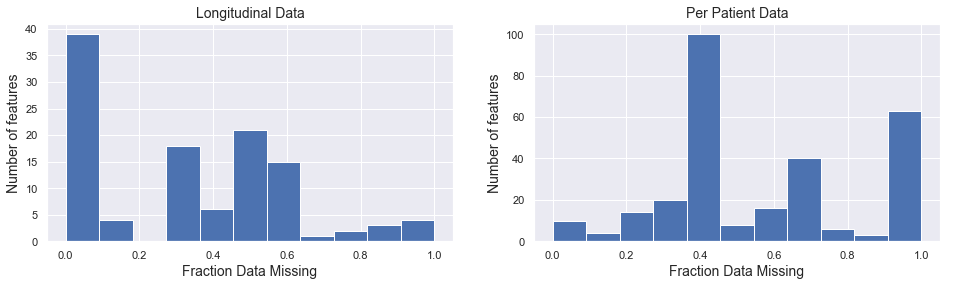

In [11]:
pct_missing = merge_df.isna().sum(0)/merge_df.shape[0]
pct_missing = np.sort(pct_missing)[::-1]

#plt.bar(np.arange(1,pct_missing.shape[0]+1,1),pct_missing, width=1, color=(1,.5,0), alpha=0.5, edgecolor='none')
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.hist(pct_missing, bins=np.linspace(0,1,12))
plt.title('Longitudinal Data', FontSize=14)
plt.ylabel('Number of features', FontSize=14)
plt.xlabel("Fraction Data Missing", FontSize=14)

plt.subplot(1,2,2)
pct_missing = mdf.isna().sum(0)/mdf.shape[0]
pct_missing = np.sort(pct_missing)[::-1]

#plt.bar(np.arange(1,pct_missing.shape[0]+1,1),pct_missing, width=1, color=(1,.5,0), alpha=0.5, edgecolor='none')
plt.hist(pct_missing, bins=np.linspace(0,1,12))
plt.title('Per Patient Data', FontSize=14)
plt.ylabel('Number of features', FontSize=14)
plt.xlabel("Fraction Data Missing", FontSize=14)
plt.subplots_adjust(wspace=0.2)
plt.savefig("../figures/missingness_hist.svg")

## Patient Demographics

In [12]:
def find_final_diagnosis(df): 
    final_diag = []
    groups = df.groupby('RID').groups
    for group in groups: 
        last_index = groups[group][-1]
        diagnosis = df['DX'].loc[last_index]
        final_diag.append(diagnosis)
    return final_diag

In [13]:
bl_df = merge_df.dropna(subset=["DX_bl","DX"])
bl_df = bl_df[bl_df['VISCODE'] == 'bl']
final_dx = find_final_diagnosis(bl_df)
bl_df['final_dx'] = final_dx
diagnosis = bl_df[['DX', 'final_dx', 'ORIGPROT']]


# sns.set(font_scale=1.25)
# f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (18, 5))

# ax3.hist(x = diagnosis[['DX', 'final_dx']])
# ax3.set_xlabel('Diagnostic Group')
# ax3.set_ylabel('Number of Patients')
# ax3.legend(['Baseline Diagnosis', 'Final Diagnosis'])
# ax3.set_title('Patient Distribution among Diagnostic groups')


# ax2.hist(diagnosis['ORIGPROT'])
# ax2.set_xlabel('ADNI phases')
# ax2.set_ylabel('Number of Patients')
# ax2.set_title('Patient Distribution among ADNI phases')

# ax1.hist(adnimerge2[['VISCODE']])
# ax1.set_xlabel('Months after initial visit')
# ax1.set_ylabel('Number of Patients')
# ax1.set_title('Patient data is collected over many visits')
# plt.setp(ax1.get_xticklabels(), rotation=30)

# f.savefig("Patient_Demographics.svg", format = 'svg', dpi =1000)

In [17]:
# lets sort out just the demographic measures. 
demographics  = bl_df[['DX', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTRACCAT', 'PTMARRY', 'PTETHCAT']]

C:\Users\winsl0w\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


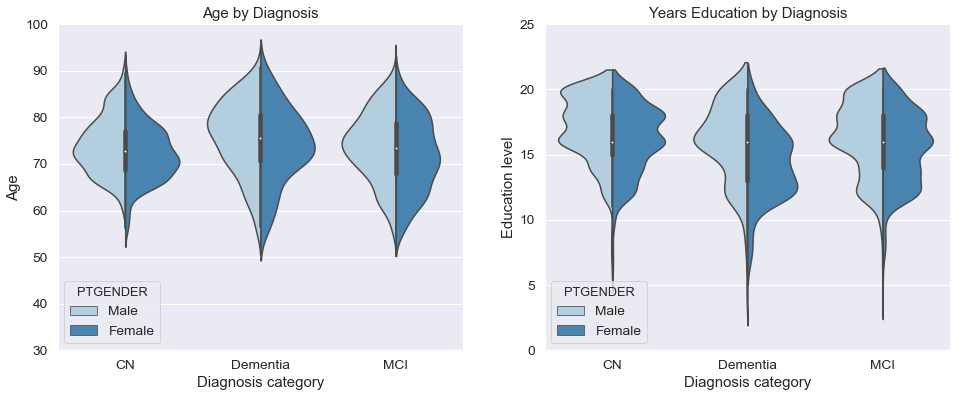

In [38]:
sns.set(font_scale = 1.25)
f, axes = plt.subplots(1, 2, figsize = (16, 6))

sns.violinplot(x = 'DX', y = 'AGE', hue = 'PTGENDER', \
               data = demographics[['DX', 'AGE', 'PTGENDER']], \
               split=True, palette='Blues', ax = axes[0])
axes[0].set_xlabel('Diagnosis category')
axes[0].set_ylabel('Age')
axes[0].set_ylim([30,100])
axes[0].set_title('Age by Diagnosis')

sns.violinplot(x = 'DX', y = 'PTEDUCAT', hue = 'PTGENDER',\
               data = demographics[['DX', 'PTEDUCAT', 'PTGENDER']],\
               split=True, palette="Blues", ax = axes[1])
axes[1].set_xlabel('Diagnosis category')
axes[1].set_ylabel('Education level')
axes[1].set_ylim([0,25])
axes[1].set_title('Years Education by Diagnosis')

f.savefig("../figures/age_edu_demo.svg")

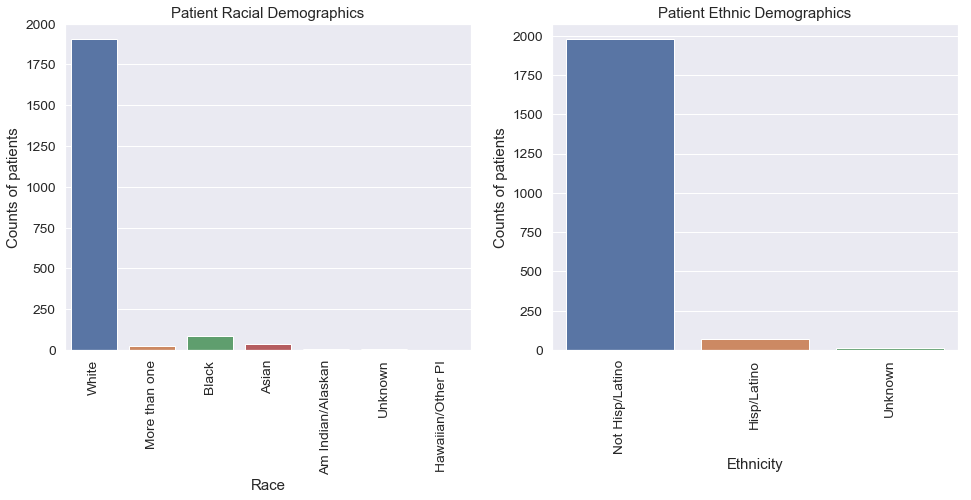

In [46]:
sns.set(font_scale = 1.25)
f, axes = plt.subplots(1, 2, figsize = (16, 6))

sns.countplot(x = 'PTRACCAT', data = demographics[['PTRACCAT']], ax = axes[0])
axes[0].set_xlabel('Race')
axes[0].set_ylabel('Counts of patients')
axes[0].set_title("Patient Racial Demographics")
plt.setp(axes[0].get_xticklabels(), rotation=90)


sns.countplot(x = 'PTETHCAT', data = demographics[['PTETHCAT']], ax = axes[1])
axes[1].set_xlabel('Ethnicity')
axes[1].set_ylabel('Counts of patients')
plt.setp(axes[1].get_xticklabels(), rotation=90)
plt.title("Patient Ethnic Demographics")
f.savefig("../figures/racial_demo.pdf")